In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import random 
import os 

from work import handler
from work import casestudy
from work import storm_tracker

from work.plots.hist import simple_hist
from work.thermo import haversine 

settings_path = 'settings/sam3d.yaml'
# Instantiate CaseStudy by passing the settings. 
# Should also create appropriate directories
hdlr = handler.Handler(settings_path)
cs = casestudy.CaseStudy(hdlr, overwrite = False ,verbose = False)
st = storm_tracker.StormTracker(cs, overwrite_storms = False, overwrite = False, verbose = True) #overwrite = True is super long, computes growth rate (triangle fit)

test = xr.open_dataset("/bdd/DYAMOND/SAM-4km/OUT_3D/DYAMOND_9216x4608x74_7.5s_4km_4608_0000001440_PP.nc")
z_targets = [300, 2000, 4000, 8000, 12000]
z_indices = [np.abs(test.z.values - target).argmin() for target in z_targets]
z_all = test.z.values.copy()
z_tropo = z_all[:np.abs(test.z.values - 15000).argmin()+1] # L'alitude de la Troposphère est à 15000m à l'équateur max non ? utiliser les pressions ? 
print("z_shear index", z_indices)
print("len z_tropo", len(z_tropo))

p_targets = [975, 800, 600, 350, 200] #mbar or hPa
p_indices = [np.abs(test.p.values-target).argmin() for target in p_targets] ## Est ce que je dois être plus flexible sur l'extraction des coordonnées de pression ? 
                                                                            ## Je peux le faire en extrayant les vents puis interpolant sur ma grille régulière ! 
p_all = test.p.values.copy()
p_tropo = p_all[:np.abs(test.z.values - 15000).argmin()+1]
print("p       index", p_indices)
test.close()

Data loaded from /homedata/mcarenso/shear/SAM3d_Tropics/var_id_days_i_t.json
Loading storms...
loading storms from netcdf
Time elapsed for loading storms: 2.88 seconds
z_shear index [6, 22, 29, 37, 45]
len z_tropo 52
p       index [6, 22, 30, 38, 45]


In [2]:
duration_min = 10
surfmaxkm2_min = 50000
region_latmin, region_latmax, region_lonmin, region_lonmax = -15, 30, -180, 180
filename_save = f"updated_storms_dmin{duration_min}_smin{surfmaxkm2_min}_lat{region_latmin}_{region_latmax}_lon{region_lonmin}_{region_lonmax}.nc"
storms_path = os.path.join(os.path.join(st.settings["DIR_DATA_OUT"], cs.name), filename_save)
ft = xr.open_dataset(storms_path)
storms = xr.open_dataset(st.file_storms)

## find some extremes (low propagation, high propagation, with a metric on scale to distinguis both capture most extremes)

In [3]:
def filter_storm(ft, region_lonmin, region_lonmax, region_latmin, region_latmax, vavg_min=None, vavg_max=None,):
    if vavg_max is None and vavg_min is None : 
        pass
        #thats okay
    elif vavg_max is None :
        ft =  ft.where(ft.INT_velocityAvg > vavg_min, drop=True)
    elif vavg_min is None :
        ft = ft.where(ft.INT_velocityAvg < vavg_max, drop=True)
    elif vavg_min is not None and vavg_max is not None : 
        print("you don't understand what you're doing my dear")
    # Apply latitude and longitude constraints
    ft = ft.where((ft.INT_latmin >= region_latmin) & (ft.INT_latmax <= region_latmax), drop=True)
    if region_lonmin>=0 : 
        ft = ft.where((ft.INT_lonmin >= region_lonmin) & (ft.INT_lonmax <= region_lonmax), drop=True)
    elif region_lonmin<0:
        ft = ft.where((ft.INT_lonmin >= 360+region_lonmin) | (ft.INT_lonmin <= region_lonmax), drop=True)
    return ft

def merge_missing_vars(ft, storms):
    variables_to_add = set(storms.data_vars) - set(ft.data_vars)
    storms_new_vars = storms[variables_to_add]
    storms_new_vars_filtered = storms_new_vars.sel(DCS_number=ft.DCS_number)
    ft_updated = xr.merge([ft, storms_new_vars_filtered])
    return ft_updated

In [4]:
ft["INT_max_accumulated_90"] = np.max(ft.LC_accumulated_prec_90th, axis=1)
ft["INT_max_instant_90"] = np.max(ft.LC_accumulated_prec_90th, axis=1)
ft["INT_sum_total"] = np.sum(ft.LC_accumulated_prec_90th, axis=1)

ft_updated = merge_missing_vars(ft, storms)
fft = filter_storm(ft_updated,  region_lonmin, region_lonmax, region_latmin, region_latmax, vavg_max = 2.2) #vavg_min =7.4  , vavg_max = 2.2


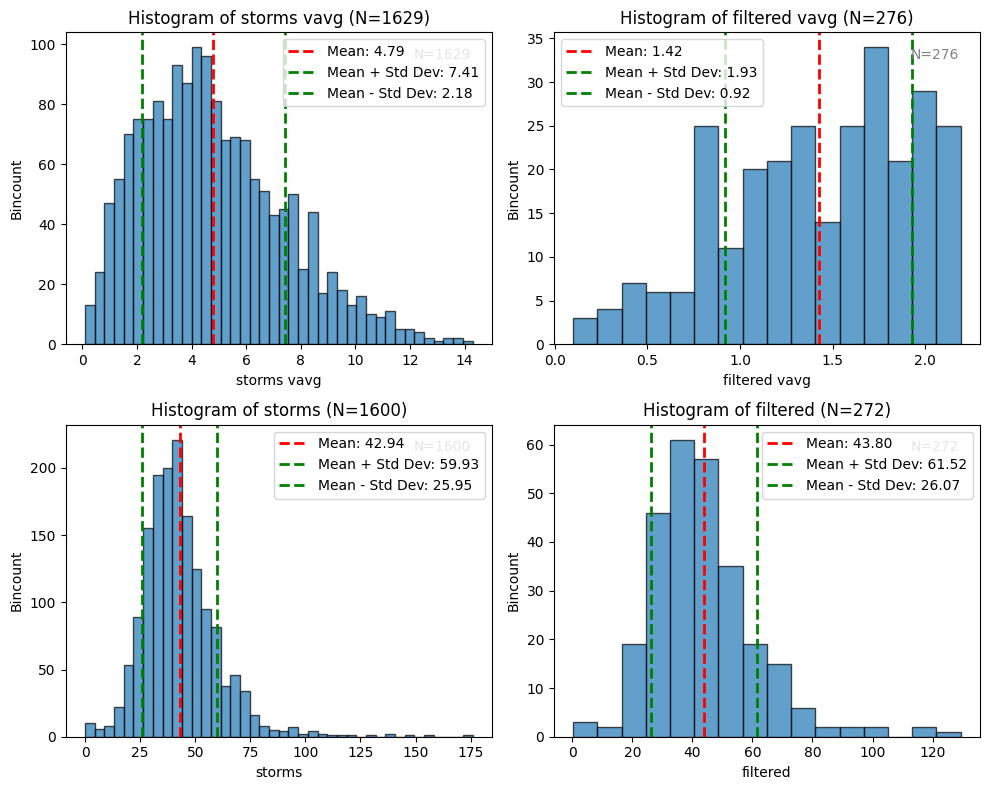

In [5]:
fig, axs = plt.subplots(2, 2, figsize = (10, 8))

simple_hist(ft.INT_velocityAvg, "storms vavg", fig=fig, ax=axs[0, 0])
region_latmin, region_latmax, region_lonmin, region_lonmax= 4, 25, -18, 25
simple_hist(fft.INT_velocityAvg, "filtered vavg", fig=fig, ax=axs[0, 1])
  

simple_hist(ft.INT_max_accumulated_90, "storms", fig=fig, ax=axs[1, 0])
simple_hist(fft.INT_max_accumulated_90, "filtered", fig=fig, ax=axs[1, 1])
plt.tight_layout()

In [21]:
fft

<xarray.Dataset>
Dimensions:                   (DCS_number: 37, time: 911)
Coordinates:
  * DCS_number                (DCS_number) int64 153400 153512 ... 284043 286121
  * time                      (time) int64 817681 817682 ... 818590 818591
Data variables: (12/56)
    INT_UTC_timeInit          (DCS_number) float64 1.472e+09 ... 1.473e+09
    INT_UTC_timeEnd           (DCS_number) float64 1.472e+09 ... 1.473e+09
    INT_duration              (DCS_number) float64 24.0 22.0 19.0 ... 14.5 15.5
    INT_surfcumkm2_241K       (DCS_number) float64 4.134e+06 ... 6.882e+05
    INT_velocityAvg           (DCS_number) float64 0.44 2.0 1.19 ... 1.61 0.82
    INT_surfmaxkm2_241K       (DCS_number) float64 2.65e+05 ... 5.363e+04
    ...                        ...
    INT_surfmaxPix_241K       (DCS_number) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    LC_tbavg_200K             (DCS_number, time) float64 nan nan nan ... nan nan
    INT_surfmaxkm2_200K       (DCS_number) float64 1.374e+05 ... 9.949e+03
    LC_surfPix_241K           (DCS_number, time) float64 nan nan nan ... nan nan
    LC_orientation_220K       (DCS_number, time) float64 nan nan nan ... nan nan
    INT_distance              (DCS_number) float64 38.25 158.8 ... 83.94 45.73

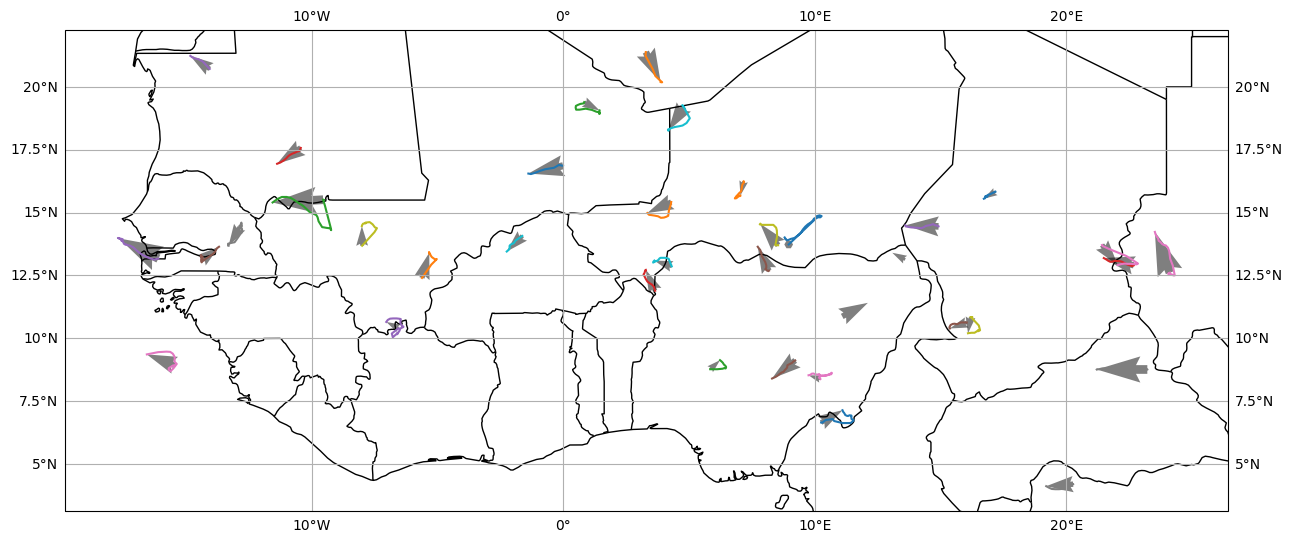

In [13]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
fig, ax = plt.subplots(1, 1, figsize=(15, 15), subplot_kw={'projection': ccrs.PlateCarree()})
ax.coastlines()
ax.add_feature(cfeature.BORDERS)
ax.gridlines(draw_labels=True)

for iDCS in fft.DCS_number.values:
    start, end, lons, lats, speeds, times, time_smax, i_smax, lons_3d, lats_3d, speeds_3d, times_3d, speed_lon_3d, speed_lat_3d  = st.get_frame_data(ft, iDCS)
    extents, slices_lon, slices_lat = st.get_extents_slices(lons_3d, lats_3d, large_scale_frame_size = 1.5)
    
    lons = (lons + 180) % 360 - 180
    lons_3d = (lons_3d + 180) % 360 - 180

    lon_smax = lons[i_smax]
    lat_smax =  lats[i_smax]
    lon_propa = lon_smax - lons[0]
    lat_propa = lat_smax - lats[0]
    print(iDCS, )
    plt.plot(lons[:i_smax+1], lats[:i_smax+1])
    plt.quiver(lons[0], lats[0], lon_propa, lat_propa, scale=1, alpha = 0.5, angles='xy', scale_units='xy')

# plt.title(save_storms_path.split("/")[-1])

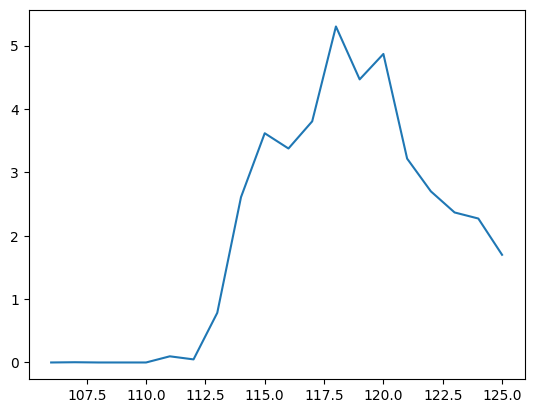

In [17]:
plt.plot(ft.sel(DCS_number = 173875).LC_instant_prec_90th)


## stats (further dev with covariance and phasing, especially once the linearity of the underlying convective line is established (r2 fit convective_line to line vs instantaneous precipitation))

In [ ]:
def plot_LC_var_1_vs_2_100_random(ft, DCS_number, LC_var_1, LC_var_2):
    # Randomly select 100 unique DCS_number values

    # Create a 10x10 grid of subplots
    fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(30, 20))
    start, end, lons, lats, speeds, times, time_smax, i_smax, lons_3d, lats_3d, speeds_3d, times_3d, speed_lon_3d, speed_lat_3d  = st.get_frame_data(ft, DCS_number)
    
    for ax, var1, var2 in axs:
        # Get the start and end indices and other necessary data

        # Extract data for plotting, ensuring they are aligned properly
        data_tb = ft.sel(DCS_number=DCS_number)[LC_var_1].values[start:end]
        data_prec = ft.sel(DCS_number=DCS_number)[LC_var_2].values[start:end]
        
        # Adjust data_tb length if necessary
        if i_smax <= len(data_tb):
            data_tb = data_tb[:i_smax+1]
        else:
            data_tb = data_tb[:i_smax]
        
        # Plot the first dataset on the left y-axis
        ax.plot(data_tb, label=LC_var_1, color='blue')
        ax.set_ylabel(LC_var_1, color='blue', fontsize=6)
        ax.tick_params(axis='y', labelcolor='blue', labelsize=6)
        
        # Create a twin y-axis to plot the second dataset
        ax2 = ax.twinx()
        ax2.plot(data_prec, label=LC_var_2, color='red')
        ax2.set_ylabel(LC_var_2, color='red', fontsize=6)
        ax2.tick_params(axis='y', labelcolor='red', labelsize=6)
        
        # Set title and adjust font size
        ax.set_title(f'DCS {DCS_number}', fontsize=8)
        
        # Optionally hide axes ticks for clarity
        ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
        ax2.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
        
        # Hide grid lines for a cleaner look
        ax.grid(False)
        ax2.grid(False)

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

plot_LC_var_1_vs_2_100_random(fft, LC_var_1, LC_var_2)

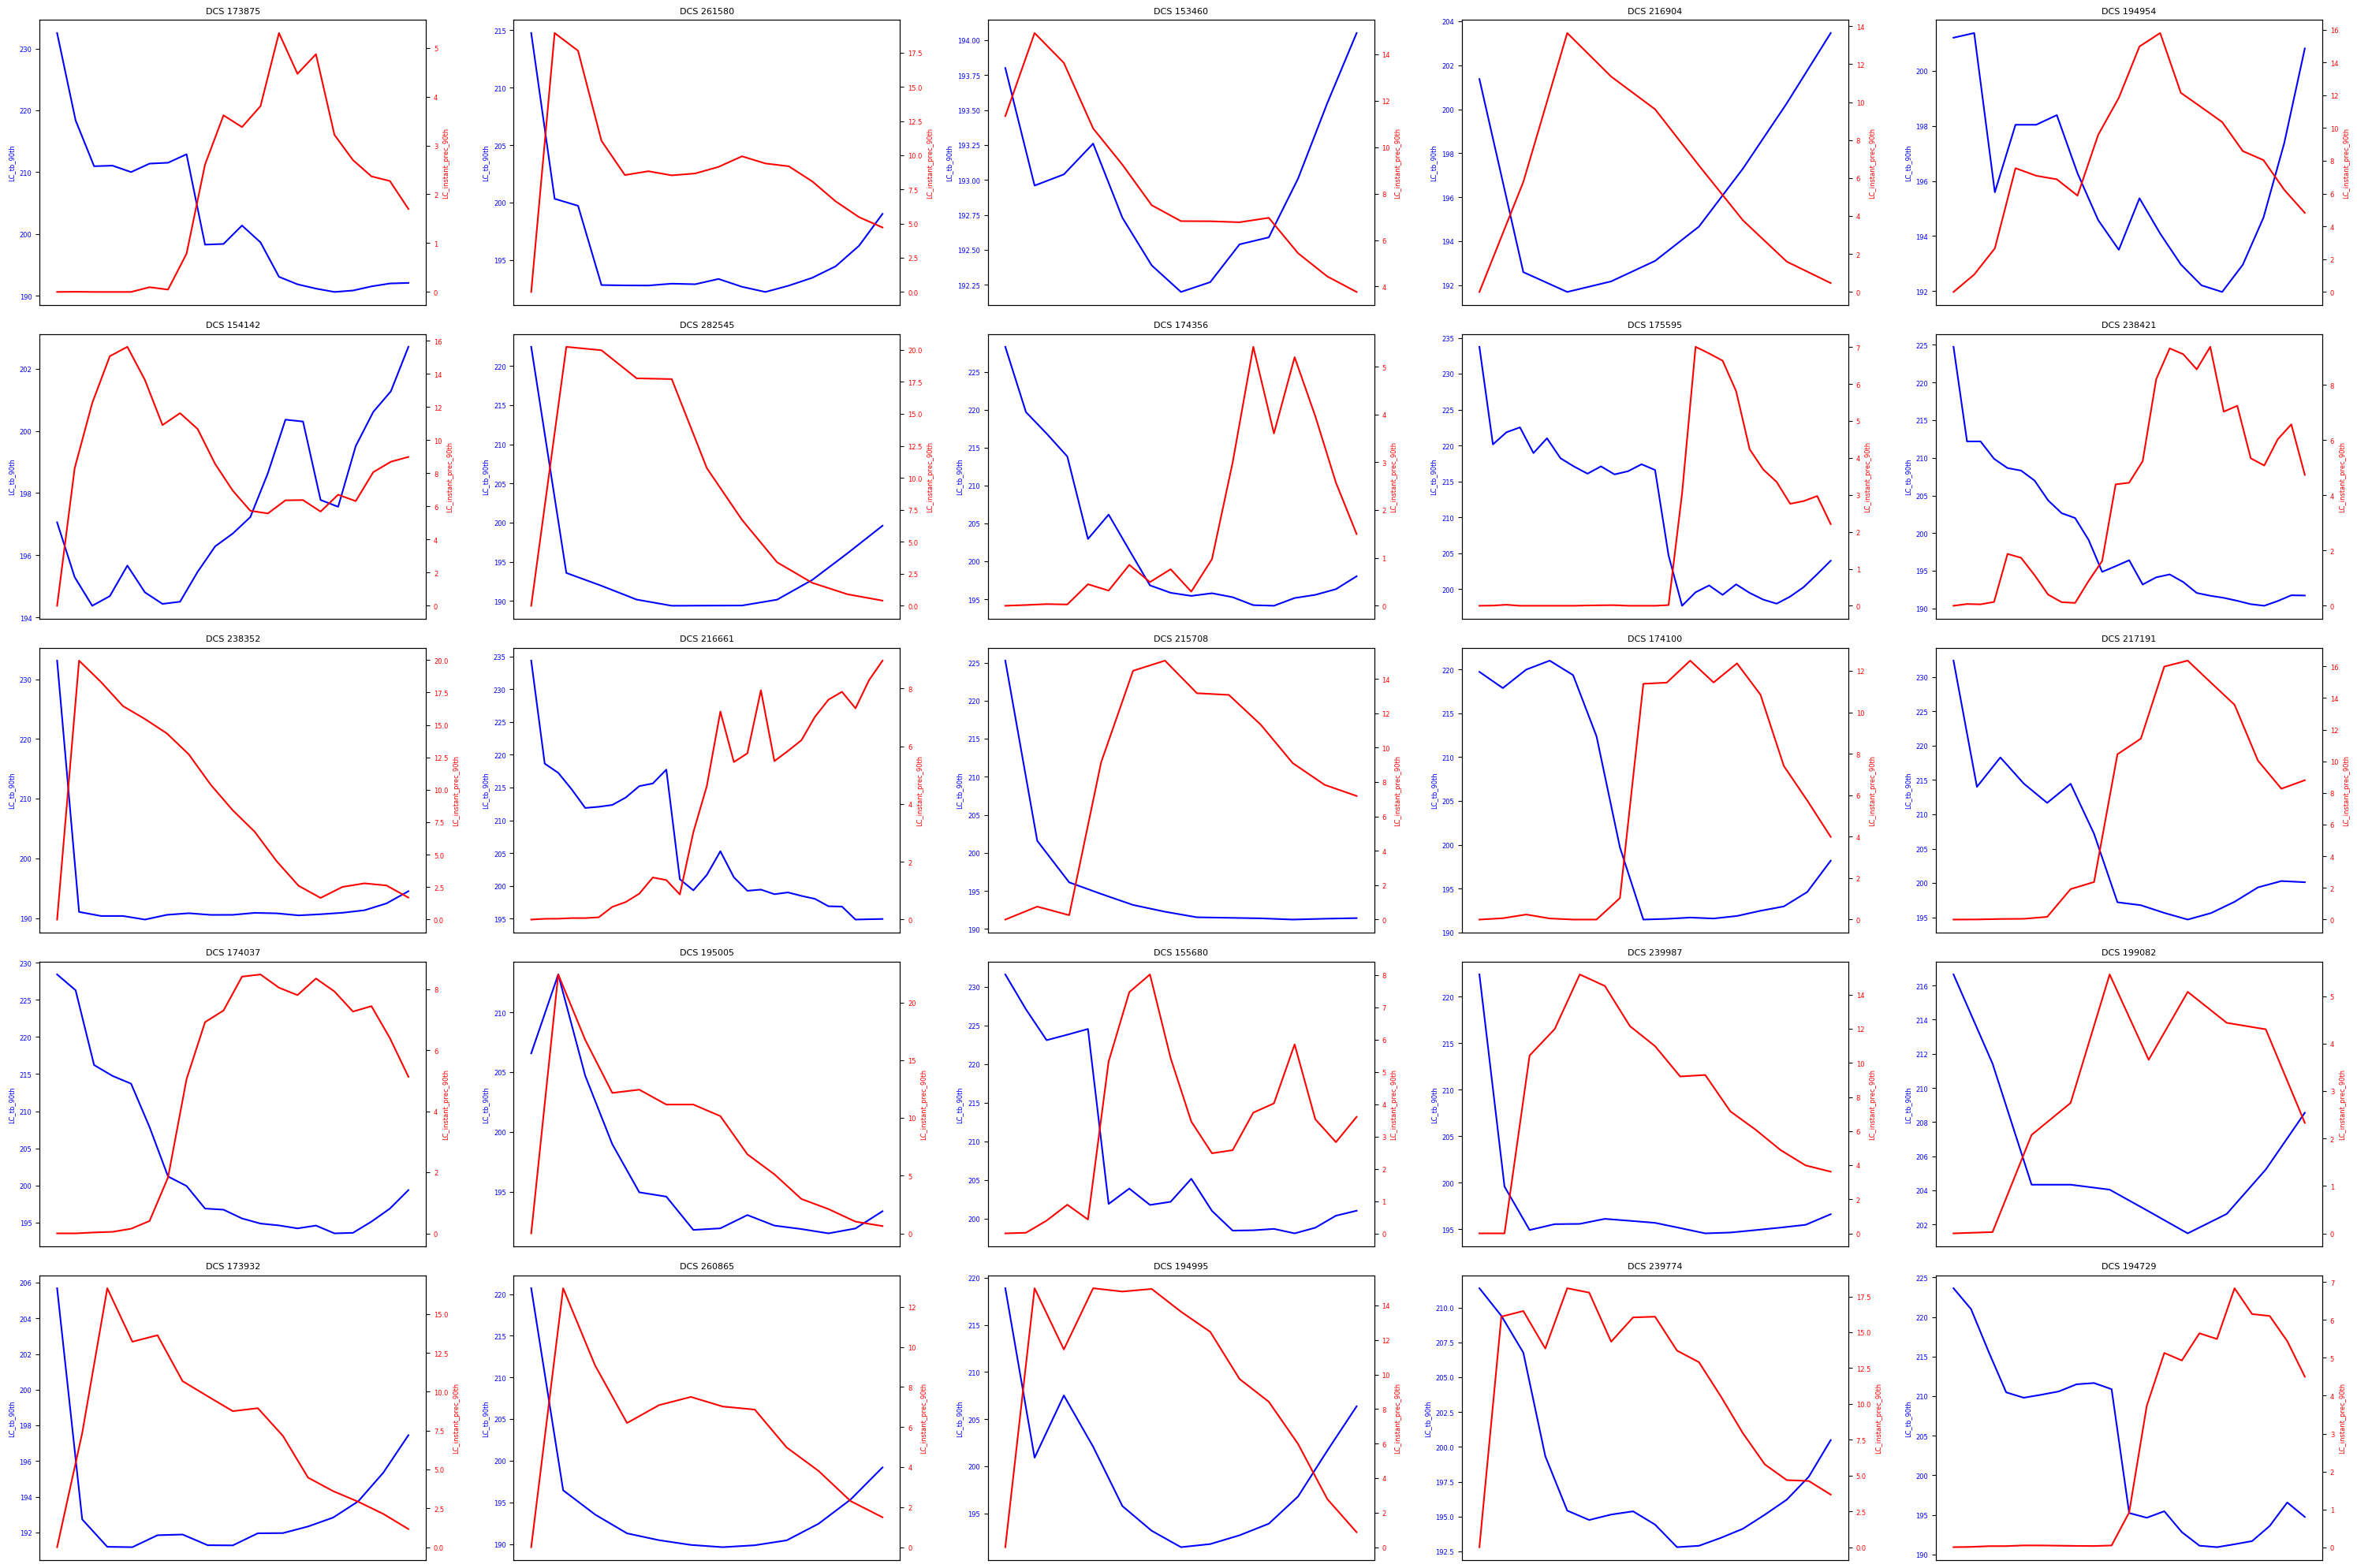

In [12]:
import numpy as np
import matplotlib.pyplot as plt


LC_var_1 = "LC_tb_90th"
LC_var_2 = "LC_instant_prec_90th"

def plot_LC_var_1_vs_2_100_random(ft, LC_var_1, LC_var_2):
    size = len(ft.DCS_number.values)
    if size>25: size=25
    # Randomly select 100 unique DCS_number values
    DCS_numbers = np.random.choice(ft.DCS_number.values, size=size, replace=False)

    # Create a 10x10 grid of subplots
    fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(30, 20))
    axes = axes.flatten()

    for idx, DCS_number in enumerate(DCS_numbers):
        ax = axes[idx]
        
        # Get the start and end indices and other necessary data
        start, end, lons, lats, speeds, times, time_smax, i_smax, lons_3d, lats_3d, speeds_3d, times_3d, speed_lon_3d, speed_lat_3d  = st.get_frame_data(ft, DCS_number)

        # Extract data for plotting, ensuring they are aligned properly
        data_tb = ft.sel(DCS_number=DCS_number)[LC_var_1].values[start:end]
        data_prec = ft.sel(DCS_number=DCS_number)[LC_var_2].values[start:end]
        
        # Adjust data_tb length if necessary
        if i_smax <= len(data_tb):
            data_tb = data_tb[:i_smax+1]
        else:
            data_tb = data_tb[:i_smax]
        
        # Plot the first dataset on the left y-axis
        ax.plot(data_tb, label=LC_var_1, color='blue')
        ax.set_ylabel(LC_var_1, color='blue', fontsize=6)
        ax.tick_params(axis='y', labelcolor='blue', labelsize=6)
        
        # Create a twin y-axis to plot the second dataset
        ax2 = ax.twinx()
        ax2.plot(data_prec, label=LC_var_2, color='red')
        ax2.set_ylabel(LC_var_2, color='red', fontsize=6)
        ax2.tick_params(axis='y', labelcolor='red', labelsize=6)
        
        # Set title and adjust font size
        ax.set_title(f'DCS {DCS_number}', fontsize=8)
        
        # Optionally hide axes ticks for clarity
        ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
        ax2.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
        
        # Hide grid lines for a cleaner look
        ax.grid(False)
        ax2.grid(False)

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

plot_LC_var_1_vs_2_100_random(fft, LC_var_1, LC_var_2)

In [ ]:
ft

# Under there is the development of build_ft_precip_trace.pu


In [ ]:
import os 

duration_min = 6
surfmaxkm2_min = 50000
region_latmin, region_latmax, region_lonmin, region_lonmax = 4, 25, -18, 25
filename_save = f"save_storms_dmin{duration_min}_smin{surfmaxkm2_min}_lat{region_latmin}_{region_latmax}_lon{region_lonmin}_{region_lonmax}.nc"
save_storms_path = os.path.join(os.path.join(st.settings["DIR_DATA_OUT"], cs.name), filename_save)

# os.remove(save_storms_path)

if not os.path.exists(save_storms_path): 
    storms = xr.open_dataset(st.file_storms)
    
    # Filter based on duration and surface area
    storms = storms.where(storms.INT_duration > duration_min, drop=True)  # 1min
    storms = storms.where(storms.INT_surfmaxkm2_241K > surfmaxkm2_min, drop=True)
    
    # Apply latitude and longitude constraints
    storms = storms.where((storms.INT_latmin >= region_latmin) & (storms.INT_latmax <= region_latmax), drop=True)
    if region_lonmin>=0 : 
        storms = storms.where((storms.INT_lonmin >= region_lonmin) & (storms.INT_lonmax <= region_lonmax), drop=True)
    elif region_lonmin<0:
        storms = storms.where((storms.INT_lonmin >= 360+region_lonmin) | (storms.INT_lonmin <= region_lonmax), drop=True)
    
    # Save the filtered storms data
    storms.to_netcdf(save_storms_path)
    storms.close()
else: 
    storms = xr.open_dataset(save_storms_path)

## FileTracking is ft
ft = storms[[ 
    "INT_UTC_timeInit", "INT_UTC_timeEnd", "INT_duration", "INT_surfcumkm2_241K", "INT_velocityAvg", "INT_surfmaxkm2_241K", ## General characteristics
    "LC_lon", "LC_lat", "LC_UTC_time", "LC_ecc_241K", "LC_orientation_241K", "LC_surfkm2_241K", "LC_tb_90th", "LC_velocity" ## General characteristics
             ]]

to_drop = []
for iDCS in ft.DCS_number.values : 
    start, end, lons, lats, speeds, times, time_smax, i_smax, lons_3d, lats_3d, speeds_3d, times_3d, speed_lon_3d, speed_lat_3d = st.get_frame_data(ft, iDCS)
    # extents, slices_lon, slices_lat = st.get_extents_slices(lons_3d, lats_3d)
    times_3d_conv = [time for time in times_3d if time <= time_smax + st.settings["TIME_RANGE"][0]]
    t = len(times_3d_conv)
    if i_smax < 0: # or t<3
        to_drop.append(iDCS)
ft = ft.drop_sel(DCS_number = to_drop)

## Valid times for 3d var are %6==0 
t=0
ft_3d = ft.sel(time=ft.time[(ft.time - st.i_t_start + cs.settings["TIME_RANGE"][0]) % 6 == 0])

In [ ]:
print(ft)

<xarray.Dataset>
Dimensions:              (DCS_number: 262, time: 911)
Coordinates:
  * DCS_number           (DCS_number) int64 153398 153400 ... 286121 287435
  * time                 (time) int64 817681 817682 817683 ... 818590 818591
Data variables: (12/14)
    INT_UTC_timeInit     (DCS_number) float64 ...
    INT_UTC_timeEnd      (DCS_number) float64 ...
    INT_duration         (DCS_number) float64 ...
    INT_surfcumkm2_241K  (DCS_number) float64 ...
    INT_velocityAvg      (DCS_number) float64 ...
    INT_surfmaxkm2_241K  (DCS_number) float64 ...
    ...                   ...
    LC_UTC_time          (DCS_number, time) float64 ...
    LC_ecc_241K          (DCS_number, time) float64 ...
    LC_orientation_241K  (DCS_number, time) float64 ...
    LC_surfkm2_241K      (DCS_number, time) float64 ...
    LC_tb_90th           (DCS_number, time) float64 ...
    LC_velocity          (DCS_number, time) float64 ...


## We want to add 3 variety of Precip information to that ft instance. 
Firstly a mean precipitation, or total precipitation

Then a "max" precipitation or instantaneous 90th

Finally a "trace" precipitation which should correspond to the 90th of accumulated precip on the eulerian grid 

In [29]:
plot_bool = False
if plot_bool : 
    import matplotlib.colors as mcolors
    from matplotlib.colors import LinearSegmentedColormap
    colors = [(1, 1, 1, 0), (0.8, 0.8, 0.8, 0.3), (0.5, 0.5, 0.5, 1)]  # RGBA for light grey to very light grey (with transparency)
    colors = [(1, 1, 1, 0), (0.0, 0.0, 0.0, 0.3), (0.5, 0.5, 0.5, 1)]  # RGBA for light grey to very light grey (with transparency)
    cmap = LinearSegmentedColormap.from_list("light_grey_scale", colors)

    prec_cmap =  plt.get_cmap("nipy_spectral")
    prec_cmap.set_bad(color=(1, 1, 1, 0)) 

In [34]:
ft_shape = tuple(ft.dims[dim] for dim in ft.dims)
LC_instant_prec_90th = np.full(ft_shape, np.nan)
LC_accumulated_prec_90th = np.full(ft_shape, np.nan)
LC_total_prec = np.full(ft_shape, np.nan)

In [ ]:
DCS_number = 215940
iDCS = np.where(ft.DCS_number.values==DCS_number)[0][0]

In [ ]:
DCS_number = np.random.choice(ft.DCS_number.values)
print("DCS_number : ", DCS_number)
DCS_number = 215940

start, end, lons, lats, speeds, times, time_smax, i_smax, lons_3d, lats_3d, speeds_3d, times_3d, speed_lon_3d, speed_lat_3d = st.get_frame_data(ft, DCS_number)
extent, slice_lon, slice_lat = st.get_full_extent_slice(lons[i_smax+1], lats[i_smax+1], large_scale_frame_size = 4)

## Load data
le_dico_long = {"latitude" : slice_lat, "longitude" : slice_lon}
le_dico_court = {    "lat" : slice_lat,       "lon" : slice_lon}
 
test = hdlr.load_seg(times[0], sel_dict = le_dico_long)[0].values #.sel(le_dico_long)
DCS_prec_acc = np.zeros_like(test)

t_smax = len(times[:i_smax+1])

total_prec = np.zeros((t_smax))
instant_prec_90th = np.zeros((t_smax))
accumulated_prec_90th = np.zeros((t_smax))

for i in range(t_smax):
    age_to_smax = i/i_smax

    ##### CLOUD MASK ######
    seg = hdlr.load_seg(times[i], sel_dict = le_dico_long)[0].values #.sel(le_dico_long)
    seg_mask = np.full_like(seg, False, dtype = bool)
    seg_mask[seg == DCS_number] = True

    nan_mask = np.isnan(seg)
    output = np.full_like(seg, 0.5, dtype = float)
    output[nan_mask] = 0
    output[seg == DCS_number] = 1
    if plot_bool :plt.contour(output, levels=[0.75], colors='red', linewidths=0.5, linestyles='solid', extent = extent) #
    output[seg == DCS_number] = 0.5
    if plot_bool :plt.imshow(output, origin = 'lower', cmap=cmap, interpolation='nearest', alpha = 1, norm=mcolors.Normalize(vmin=0, vmax=1), extent = extent)

    #### PREC ####
    prec = hdlr.load_var(cs, "Prec", times[i], sel_dict = le_dico_court).values
    prec[~seg_mask] = 0 # 1st timestep of seg_mask looks empty... 

    DCS_prec_acc+=prec
    DCS_prec_acc_masked = np.ma.masked_less_equal(DCS_prec_acc, 1)

    if plot_bool :plt.imshow(DCS_prec_acc_masked, origin = 'lower', cmap = prec_cmap, interpolation='nearest', alpha = 1, extent = extent)
    if plot_bool :plt.colorbar()


    total_prec[i] = np.sum(prec)
    instant_prec_90th[i] = np.percentile(prec[seg_mask], 90) if np.any(seg_mask) else 0 
    accumulated_prec_90th[i] = np.percentile(DCS_prec_acc[seg_mask], 90) if np.any(seg_mask) else 0 
    
    if plot_bool : plt.show()

DCS_number :  283769


In [ ]:
## it looks complicated ? well fu 
LC_instant_prec_90th[iDCS][start:end][:i_smax+1] = instant_prec_90th
LC_total_prec[iDCS][start:end][:i_smax+1] = total_prec
LC_accumulated_prec_90th[iDCS][start:end][:i_smax+1] = accumulated_prec_90th

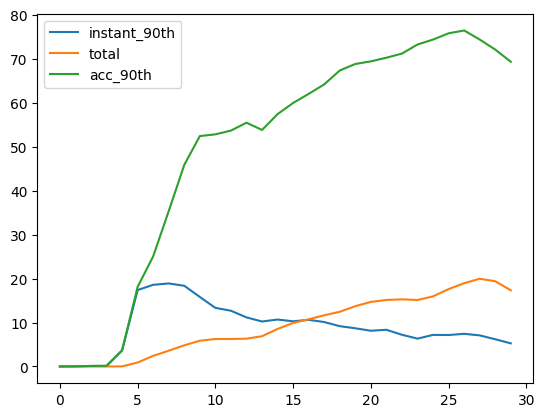

In [28]:
# total_prec = np.zeros((t_smax))
# instant_prec_90th = np.zeros((t_smax))
# accumulated_prec_90th = np.zeros((t_smax))
plt.plot(instant_prec_90th, label = "instant_90th")
plt.plot(total_prec/1000, label = "total")
plt.plot(accumulated_prec_90th, label = "acc_90th")
plt.legend()